In [49]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.linalg import inv, eig

In [50]:
goeblue = '#153268'
midblue = '#0093c7'
grey60 = '#878787'
skyblue = '#84bfea'

cmprior = sns.blend_palette([(1,1,1,0), skyblue], as_cmap=True)
rcmprior = sns.blend_palette([skyblue, (1,1,1,0)], as_cmap=True)

cmpost = sns.blend_palette([(1,1,1,0), midblue], as_cmap=True)
rcmpost = sns.blend_palette([midblue, (1,1,1,0)], as_cmap=True)

cmlik = sns.blend_palette([(1,1,1,0), 'deeppink'], as_cmap=True)
rcmlik = sns.blend_palette(['deeppink', (1,1,1,0)], as_cmap=True)

cm4 = sns.blend_palette([(1,1,1,0), midblue], as_cmap=True)
rcm4 = sns.blend_palette([midblue, (1,1,1,0)], as_cmap=True)

# Exercise Sheet 3 - Practical: Gaussian Inference

### Defining the model

Here, we will define the model that we will do Gaussian inference on functions with. 

Task:
- [4] Fill in the computations of mean and variance for both $w$ and $f$.

Definition of the base class.

In [27]:
class GaussInference:
    def __init__(self, x, y, phi, sigma_noise=2, mu_prior=None, S_prior=None, yrange=None, xoffset=.5, prior_var=1, shuffle=True):
        """
        Model for Gaussian inference

        Args:
            x (array): 1D array of x values of the data
            y (array): 1D array of y values of the data
            phi(func): features to fit the data with
            sigma_noise(float): standard deviation of the noise
            mu_prior(array): 1D array with length = number of features. Mean of the prior. Defaults to 0.
            S_prior(array): 2D square matrix of size (number of features, number of features). Defaults to a diagonal matrix with values "prior_var"
            yrange(tuple): range of y values.
            xoffset(float): offset of x values
            prior_var(float): see "S_prior"

        """

        # assign class attributes
        self._x = x
        self._y = y
        self.dim = phi(x).shape[0]
        self.phi = phi
        self.sigma_noise = sigma_noise

        # define shuffle
        self.shuffle = np.arange(len(x))
        if shuffle:
            self.shuffle = np.random.permutation(len(x))

        # if the y range is not specified, create it according to the y values
        if yrange is None:
            ymax = np.ceil(np.abs(y).max() + 1)
            ymin = -ymax
        else:
            ymin, ymax = yrange

        xmin = x.min() - xoffset
        xmax = x.max() + xoffset

        self.xrange = xmin, xmax
        self.yrange = ymin, ymax

        # create the grid
        self.Xf, self.Yf = np.mgrid[xmin:xmax:.025, ymin:ymax:.025]
        self.xy = np.dstack((self.Xf, self.Yf))
        self.xf = self.Xf[:, 1]

        # define prior distribution as a multivariate normal
        self.mu_prior = np.zeros(self.dim) if mu_prior is None else mu_prior
        self.S_prior = np.eye(self.dim) * prior_var if S_prior is None else S_prior
        self.prior = stats.multivariate_normal(self.mu_prior, self.S_prior)

    # These two properties allow to shuffle the data so the left-out data points are not consecutive
    @property
    def x(self):
        return self._x[self.shuffle]

    @property
    def y(self):
        return self._y[self.shuffle]

Define the mean and variance of the posterior distribution over $w$.

In [73]:
class GaussInference(GaussInference):
    def w_posterior_mean(self, n):
        """
        Computes the mean of the posterior of w.

        Args:
            n (int): number of datapoints

        """
        mu_prior = self.mu_prior
        S_prior = self.S_prior
        phi_x = self.phi(self.x)[:, :n]
        y_x = self.y[:n]

        mu_wx = mu_prior + S_prior @ phi_x @ inv(phi_x.T @ S_prior @ phi_x + np.eye(n) * sigma_noise**2) @ (y_x - phi_x.T @ mu_prior)
        return mu_wx

    def w_posterior_variance(self, n):
        """
        Computes the variance of the posterior of w.

        Args:
            n (int): number of datapoints

        """
        mu_prior = self.mu_prior
        S_prior = self.S_prior
        phi_x = self.phi(self.x)[:, :n]
        y_x = self.y[:n]

        S_wx = S_prior - S_prior @ phi_x @ inv(phi_x.T @ S_prior @ phi_x + np.eye(n) * sigma_noise**2) @ phi_x.T @ S_prior
        return S_wx

    def w_posterior(self, n):
        """
        Computes the posterior of w for n datapoints

        Args:
            n (int): number of datapoints

        """
        mu_wx = self.w_posterior_mean(n)
        S_wx = self.w_posterior_variance(n)
        return stats.multivariate_normal(mu_wx, S_wx)

    def w_posterior_samples(self, n, m):
        """
        Draws m samples of the posterior of w which was computed on n datapoints. This is used to plot some example fits to the data.

        Args:
            n (int): number of datapoints
            m (int): number of samples to draw

        """
        posterior = self.w_posterior(n)
        w = posterior.rvs(m)
        phi = self.phi(self.xf)
        return w, w @ phi

Define the mean and variance of the posterior distribution over $f$.

In [74]:
class GaussInference(GaussInference):
    def f_posterior_mean(self, n):
        """
        Computes the mean of the posterior of f.

        Args:
            n (int): number of datapoints

        """
        phi = self.phi(self.xf)
        phi_x = self.phi(self.x)[:, :n]
        mu_prior = self.mu_prior
        S_prior = self.S_prior
        y_x = self.y[:n]

        mu_fx = phi.T @ self.w_posterior_mean(n)
        return mu_fx

    def f_posterior_variance(self, n):
        """
        Computes the variance of the posterior of f.

        Args:
            n (int): number of datapoints

        """
        phi = self.phi(self.xf)
        phi_x = self.phi(self.x)[:, :n]
        S_prior = self.S_prior

        S_fx = phi.T @ self.w_posterior_variance(n) @ phi
        s_fx = np.diag(S_fx)
        return s_fx

    def f_posterior_uncertainty_map(self, n):
        """
        Computes the uncertainty map of the posterior of f. This is used to visualize the posterior of f.

        Args:
            n (int): number of datapoints

        """
        mu_post = self.f_posterior_mean(n)
        s_f = self.f_posterior_variance(n)
        return np.exp(-.5 * (self.Yf - mu_post[:, None])**2 / s_f[:, None])

# Part 1: Toy dataset

In this part, you will fit the toy dataset from the lecture and apply Gaussian inference on it.

### Load and visualize data

In [6]:
dat = np.genfromtxt('toy_data.csv', delimiter=',')
x, y = dat.T

In [86]:
print(x)

[-5.00584795 -4.47953216 -3.95321637 -3.38791423 -2.88109162 -2.35477583
 -1.86744639 -1.3411306  -0.77582846 -0.24951267  0.23781676  0.76413255
  1.3294347   1.81676413  2.32358674  2.86939571  3.41520468  3.94152047
  4.48732943  4.99415205]


Let's visualize the data with the assumed standard deviation of the noise to be 2.

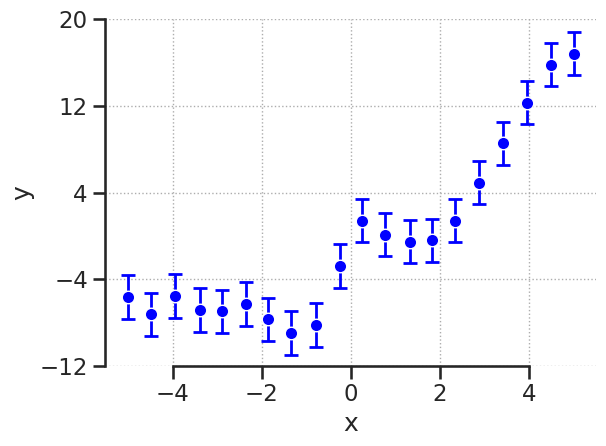

In [18]:
sigma_noise = 2

sns.set_context('talk')
with sns.axes_style('ticks'):
    fig, ax = plt.subplots()
    ax.errorbar(x, y, 0*y + sigma_noise, fmt='none', capsize=5, linewidth=2, color='blue', capthick=2)
    ax.plot(x,y, 'ow', mfc= 'blue')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_ylim((-12, 20))
    ax.set_yticks(np.linspace(-12, 20, 5))
    sns.despine(trim=True)
    ax.grid(linestyle=':', lw=1, color='#adadad')
    fig.tight_layout()

### Features

Here, we define the features that we want to fit the data with. We prepared two sets of features for you: "linear" and radial basis functions "rbf". Only uncomment the basis functions that you want to use for your fit.

In [19]:
#####  'linear'
def linear_phi(x):
    """
    Linear basis functions as features.
    :param x: input data
    :return: phi: features
    """
    return np.vstack([0 * x + 1, x])

#####  'rbf'
def rbf_phi(x, rbf_range=None):
    """
    Radial basis functions as features.
    :param x: input data
    :param rbf_range: range of the radial basis functions
    :return: phi: features
    """
    if rbf_range is None:
        rbf_range = np.arange(-8, 9)

    return np.vstack([0 * x + 1] + [np.exp(-(x - i)**2) for i in rbf_range])

### Plot

In [51]:
# Utility function to plot the uncertainty map of the posterior of f
# Utility function to plot the uncertainty map of the posterior of f
def plot_uncertainty_map(model, n_datapoints):
    P_fx = model.f_posterior_uncertainty_map(n_datapoints)
    w_posterior, f_posterior = model.w_posterior_samples(n_datapoints, 3)

    with sns.axes_style('whitegrid'):
        fig, ax2 = plt.subplots(figsize=(10,5))

        ax2.pcolormesh(model.Xf, model.Yf, P_fx, cmap=cmpost, alpha=.5, rasterized=True, shading='gouraud')
        ax2.contour(model.Xf, model.Yf, P_fx, levels=np.linspace(0.1, 0.9, 3) * P_fx.max(), cmap=rcmpost, linewidths=.5)

        ax2.set_xlabel('x')
        ax2.set_ylabel('f(x)')
        ax2.grid(linestyle=':')

        ax2.errorbar(x, y, 0 * y + 2, fmt='none', capsize=5, linewidth=2, color='k', capthick=2)
        ax2.plot(x, y, 'ow', mfc='k')

    for i, xi, yi in zip(range(n_datapoints), model.x, model.y):
        ax2.errorbar(xi, yi, 0 * yi + sigma_noise, fmt='none', capsize=5, linewidth=2, color='deeppink', capthick=2)
        ax2.plot(xi, yi, 'ow', ms=10, mfc='deeppink', zorder=50)

    for w, f in zip(w_posterior, f_posterior):
        ax2.plot(model.xf, f, '--', lw=2, color=midblue)

    ax2.set_ylim(model.yrange)
    fig.tight_layout()
    plt.show()

Task:
- [1] Fit the data once with linear and once with rbf basis functions. Use 1 datapoint each. What can you say about the quality of the fit?

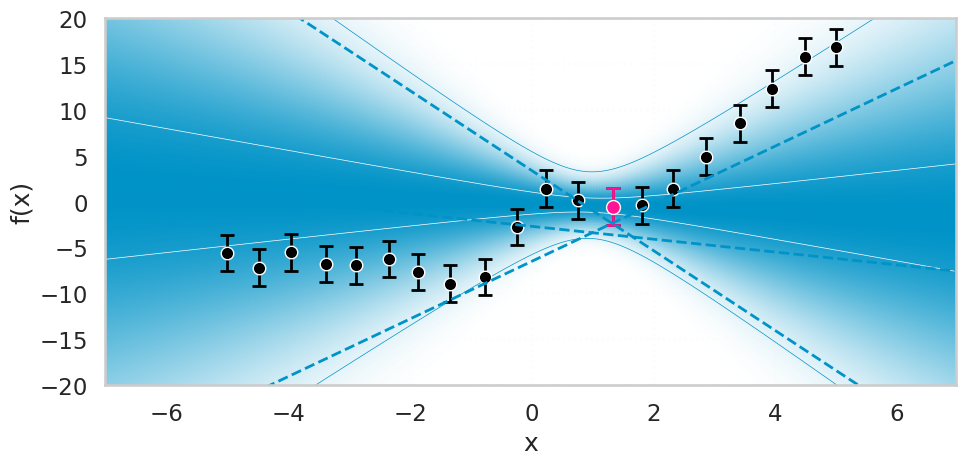

In [87]:
n_datapoints = 1

model = GaussInference(x, y, linear_phi, sigma_noise=sigma_noise, yrange=(-20,20), xoffset=2, prior_var=10)

plot_uncertainty_map(model, n_datapoints)

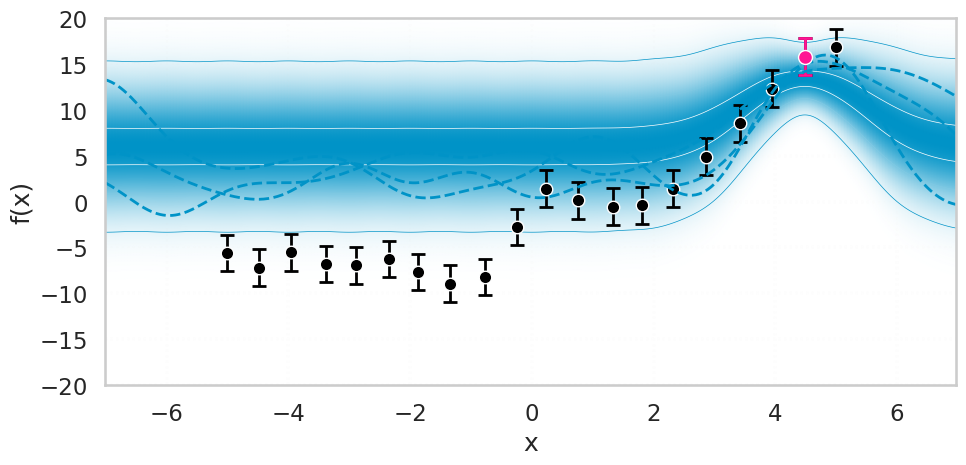

In [88]:
n_datapoints = 1

model = GaussInference(x, y, rbf_phi, sigma_noise=sigma_noise, yrange=(-20,20), xoffset=2, prior_var=10)

plot_uncertainty_map(model, n_datapoints)

Answer: What is the quality of the fit?

Your answer here

- [1] Now add more and more datapoints. What do you observe? How does the choice of basis function influence the result?

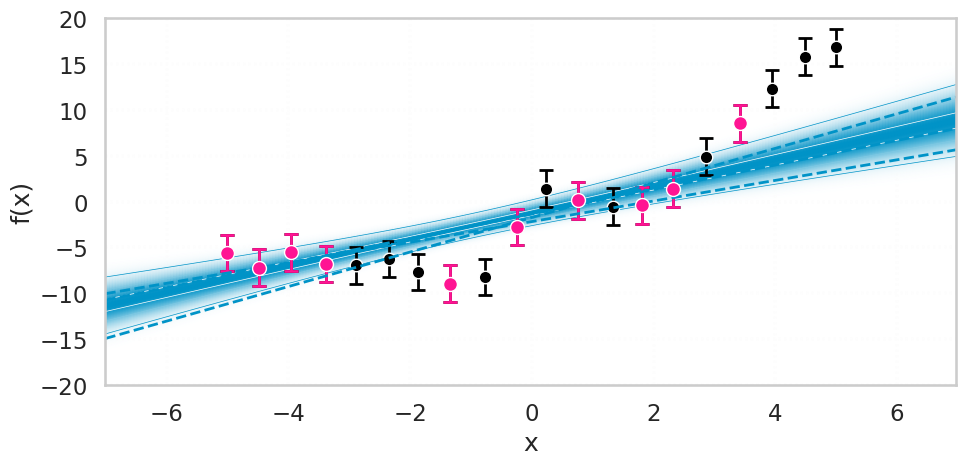

In [91]:
n_datapoints = 10

model = GaussInference(x, y, linear_phi, sigma_noise=sigma_noise, yrange=(-20,20), xoffset=2, prior_var=10)

plot_uncertainty_map(model, n_datapoints)

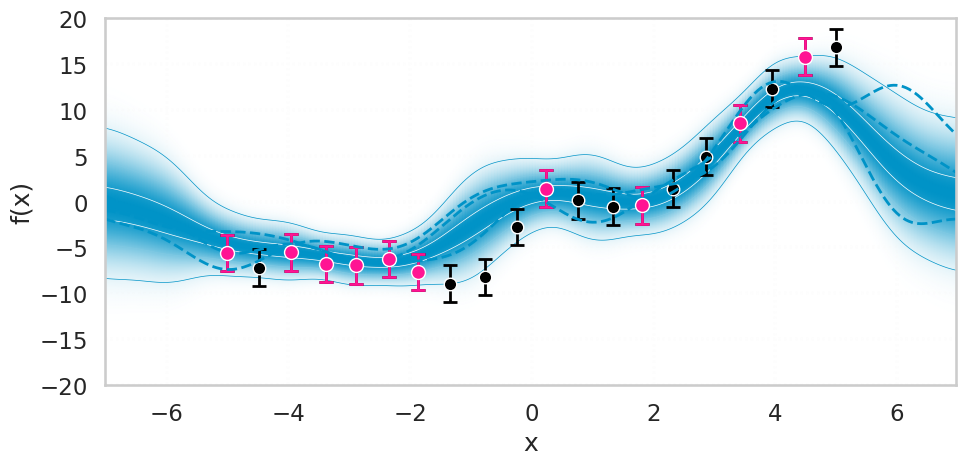

In [90]:
# Repeat the same for more datapoints

n_datapoints = 10

model = GaussInference(x, y, rbf_phi, sigma_noise=sigma_noise, yrange=(-20,20), xoffset=2, prior_var=10)

plot_uncertainty_map(model, n_datapoints)

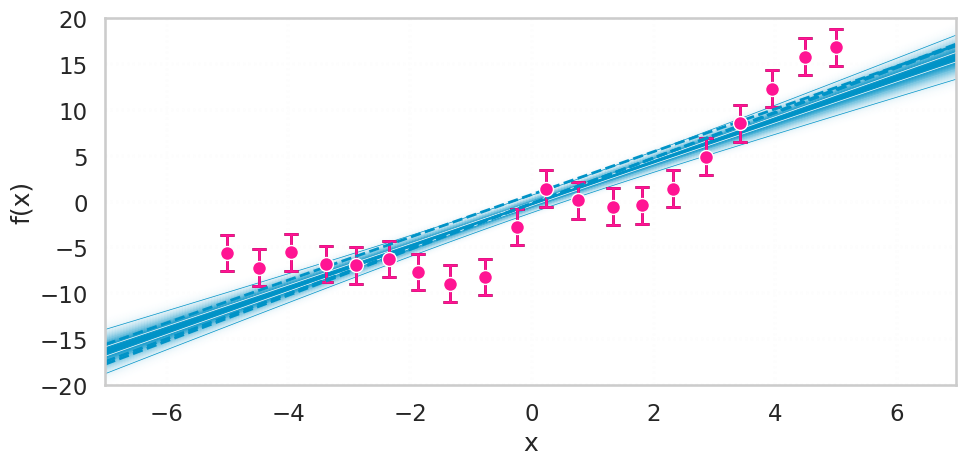

In [92]:
n_datapoints = 20

model = GaussInference(x, y, linear_phi, sigma_noise=sigma_noise, yrange=(-20,20), xoffset=2, prior_var=10)

plot_uncertainty_map(model, n_datapoints)

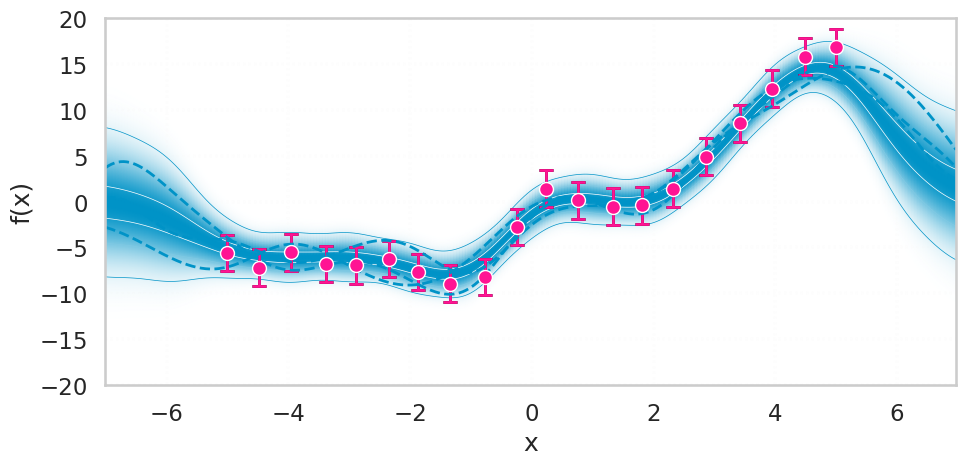

In [93]:
n_datapoints = 20

model = GaussInference(x, y, rbf_phi, sigma_noise=sigma_noise, yrange=(-20,20), xoffset=2, prior_var=10)

plot_uncertainty_map(model, n_datapoints)

Answer: What do you observe? How does the choice of basis function influence the result?

Your answer here

# Part 2: CO2 in the atmosphere

Here you will work with a dataset containing the weekly carbon-dioxide concentration averages derived from continuous air samples for the Mauna Loa Observatory, Hawaii, U.S.A (https://www.openml.org/d/41187). The dataset is challenging to fit because the CO2 concentration in the atmosphere is subject to two effects at the same time: Seasonal fluctuation and an overall tendency to increase due to climate change and human CO2 emissions.

### Load and visualize data

In [94]:
dataset_size = 400
sigma_noise = 1 # Assume the noise is 1, because we don't know the true value

data = np.genfromtxt('mauna-loa-atmospheric-co2-2.csv', delimiter=',')

year = data[:, 0]
month = data[:, 1]
day = data[:, 2]
co2 = data[:, 6]
time = year + month / 12 + day / 365

y = co2[1:dataset_size + 1]
x = time[1:dataset_size + 1]

# Standardize x values for numerical reasons
x = (x - x.mean()) / x.std()

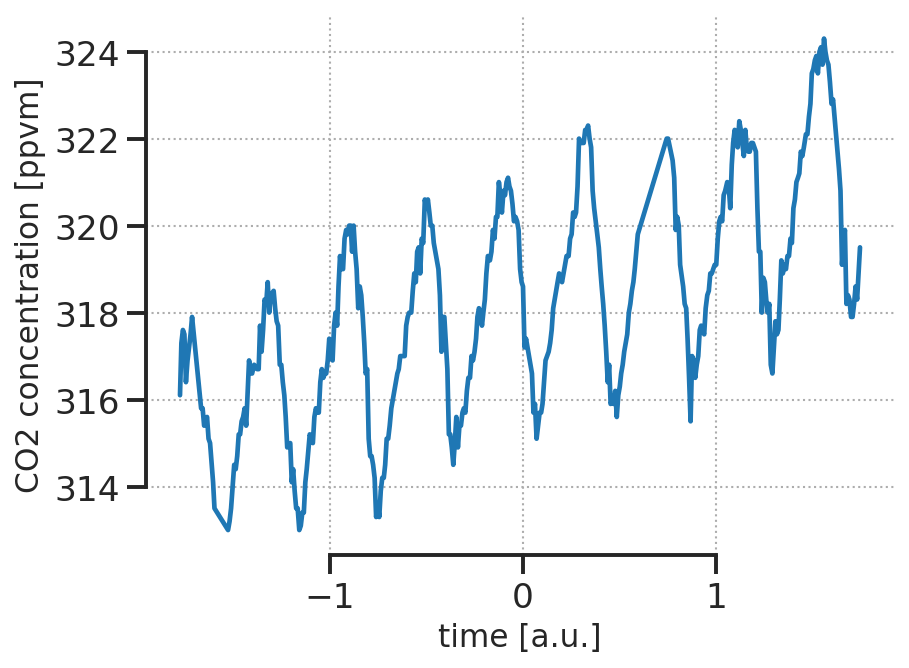

In [95]:
sns.set_context('talk')
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(dpi=150)
    ax.plot(x, y)
    ax.set_xlabel('time [a.u.]', fontsize=15)
    ax.set_ylabel('CO2 concentration [ppvm]', fontsize=15)
    sns.despine(trim=True)
    ax.grid(linestyle=':', lw=1, color='#adadad')
    fig.tight_layout()

Task:
- [1] Fit the data with the rbf basis functions using 200 datapoints out of 400. Why do they perform poorly, what is missing?

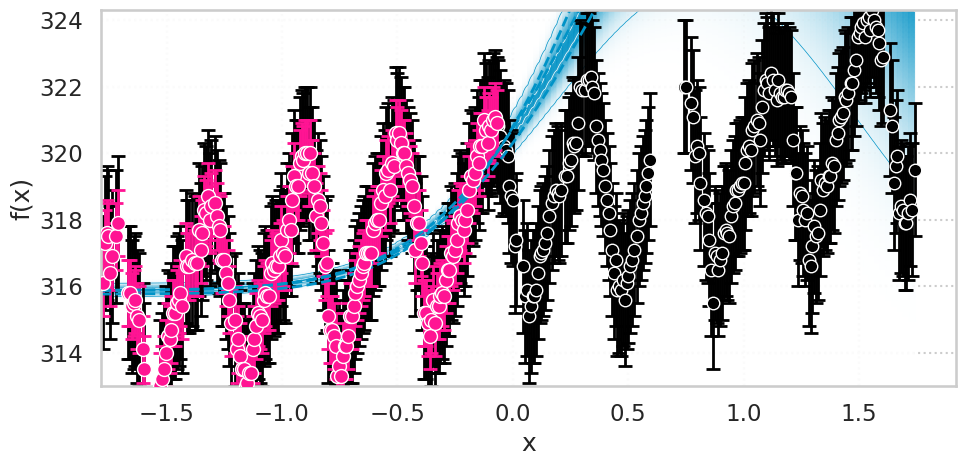

In [96]:
from functools import partial

n_datapoints = 200

model = GaussInference(x, y,
                       phi=partial(rbf_phi, rbf_range=np.linspace(1, 1.3, 20)),
                       sigma_noise=sigma_noise,
                       yrange=(y.min(), y.max()),
                       xoffset=0.01,
                       prior_var=10,
                       shuffle=False)

plot_uncertainty_map(model, n_datapoints)

Answer: Why do they perform poorly, what is missing?

Your answer here

- [1] Define your own set of basis functions that overcome these issues and fit the data better

In [111]:
### 'your set of basis functions'
def my_phi(x, p = 1, range=None):
    
    if range is None:
        range = np.arange(-8, 9)
    
    return np.vstack([0 * x + 1] + [np.exp(-2/(np.sin(np.pi *(x-i)**2 / p)**2)) for i in range])


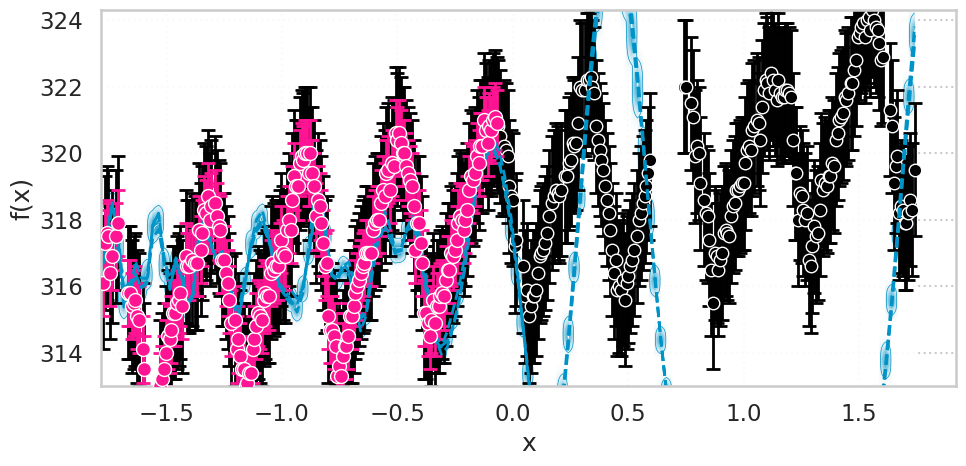

In [115]:
n_datapoints = 200

model = GaussInference(x, y,
                       phi=partial(my_phi, p= 1, range=np.linspace(1, 1.3, 20)),
                       sigma_noise=sigma_noise,
                       yrange=(y.min(), y.max()),
                       xoffset=0.01,
                       prior_var=10,
                       shuffle=False)

plot_uncertainty_map(model, n_datapoints)